# Necessary Libaries

In [64]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# Import the Dataset

In [65]:
df = pd.read_csv('../input/heart-failure-prediction/heart.csv')

FileNotFoundError: [Errno 2] No such file or directory: '../input/heart-failure-prediction/heart.csv'

# Dataset Overview

| Variable | Definition | Guide |
| --- | --- | --- |
| Age | age of the patient | years |
| Sex | sex of the patient | M: Male, F: Female |
| ChestPainType | chest pain type | <br>TA: Typical Angina<br><br>ATA: Atypical Angina<br><br>NAP: Non-Anginal Pain<br><br>ASY: Asymptomatic<br> |
| RestingBP | resting blood pressure | mm Hg |
| Cholesterol | serum cholesterol | mm/dl |
| FastingBS | fasting blood sugar | 1: if FastingBS > 120 mg/dl<br><br>0: otherwise |
| RestingECG | resting electrocardiogram results | Normal: Normal<br><br>ST: having ST-T wave abnormality<br><br>LVH: showing probable or definite left ventricular hypertrophy by Estes' criteria |
| MaxHR | maximum heart rate achieved | Numeric value between 60 and 202 |
| ExerciseAngina | exercise-induced angina | Y: Yes, N: No |
| Oldpeak | oldpeak = ST | Numeric value measured in depression |
| ST_Slope | the slope of the peak exercise ST segment | Up: upsloping, Flat: flat, Down: downsloping |
| HeartDisease | output class | 1: heart disease, 0: Normal |

In [ ]:
df

In [ ]:
df.shape

In [ ]:
df.info()

# EDA (Exploratory Data Analysis)

In [ ]:
df.describe()

In [ ]:
plt.figure(figsize=(18, 11))
matrix = np.triu(df.corr())
sns.heatmap(df.corr(),center= 0, annot=True, linewidth=0.8, mask=matrix)

plt.title('Features Correlation Heatmap', fontsize = 25)

In [ ]:
fig, axes = plt.subplots(2,2, figsize = (15,8))
fig.suptitle('Useful Histograms', fontsize = 18)

sns.histplot(data = df, x = 'Age', kde= True, bins = 25, ax = axes[0,0])
sns.histplot(data = df, x = 'RestingBP', kde= True, bins = 25, ax = axes[0,1])
sns.histplot(data = df, x = 'Oldpeak', kde= True, bins = 25, ax = axes[1,0])
sns.histplot(data = df, x = 'Cholesterol', kde= True, bins = 25, ax = axes[1,1])

In [ ]:
fig, axes = plt.subplots(3,2, figsize = (15,15))
fig.suptitle('Useful Countplots', fontsize = 18)

sns.countplot(data = df, x = 'HeartDisease', ax = axes[0,0])
sns.countplot(data = df, x = 'Sex', ax = axes[0,1])
sns.countplot(data = df, x = 'RestingECG', ax = axes[1,0])
sns.countplot(data = df, x = 'ChestPainType', ax = axes[1,1])
sns.countplot(data = df, x = 'ExerciseAngina', ax = axes[2,0])
sns.countplot(data = df, x = 'FastingBS', ax = axes[2,1])

In [ ]:
fig, axes = plt.subplots(2,2, figsize = (16,10))
fig.suptitle('Useful Boxplots', fontsize = 18)

sns.boxplot(data = df, x = 'HeartDisease', y = 'Age', ax = axes[0,0])
sns.boxplot(data = df, x = 'Sex', y = 'Age', ax = axes[0,1])
sns.boxplot(data = df, x = 'HeartDisease', y = 'MaxHR', ax = axes[1,0])
sns.boxplot(data = df, x = 'FastingBS', y = 'Cholesterol', ax = axes[1,1])

# Data Cleaning

In [ ]:
df.isnull().sum()

no missing data

according to Oldpeak histogram there are some negative data in the dataset... we need to deal with them cause oldpeak can not be negative...

In [ ]:
df[df['Oldpeak']<0]

In [ ]:
df.loc[df['Oldpeak']<0,'Oldpeak'] = df[df['Oldpeak']<0]['Oldpeak']*(-1)

In [ ]:
df[df['Oldpeak']<0]

also in cholesterol histogram we can see there are some zero values that we want to deal with them.

In [ ]:
#also in cholesterol histogram we can see there are some zero values that we want to deal with them.
len(df[df['Cholesterol'] == 0].index)/len(df.index)

 %18.7 of our dataset have zero cholesterol.

**cholesterol** is highly correlated with **FastingBS** So it's better to guess the **cholesterol** of the patients according to their **FastingBS**...

In this section we use the **median** to keep the cholesterol distribution in each fasting blood sugar class unchanged. 

In [ ]:
for i in range(2):
    
    df.loc[(df['Cholesterol'] == 0) & (df.FastingBS == i), 'Cholesterol'] = df[(df['FastingBS'] == i) & (df['Cholesterol'] != 0)]['Cholesterol'].median()

Next feature that need to be cleaned is **RestingBP**...
according to the histogram it has some zero values. we know that blood pressure can not possibly be zero...
and according to the heatmap **RestingBP** is highly correlated with **Age**

so same as previous feature we are going to fill the zero values of resting blood pressure...

In [ ]:
df[df['RestingBP'] == 0]

In [ ]:
df.loc[df['RestingBP'] == 0, 'RestingBP'] = df['RestingBP'].median()

# Categorical Features (Dummy variables)

In [ ]:
df = pd.get_dummies(df, drop_first=True)

In [ ]:
df.head()

Ready to build some models

# Model Building

In [ ]:
#Split Dataset into X and Y
X = df.drop('HeartDisease', axis = 1)
y = df['HeartDisease']

### defining an evaluation function

In [ ]:
#libraries
#In python’s sklearn implementation of the Support Vector Classification model
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, plot_confusion_matrix
from sklearn.metrics import plot_precision_recall_curve, plot_roc_curve

In [ ]:
def Eval_Report(model, y_pred):
    
    print('********* EVALUATION REPORT ********* \n')
    #Evaluate model using confusion matrix
    print('CONFUSION MATRIX : \n')
    print(confusion_matrix(y_test, y_pred))
    print('\nCLASSIFICATION REPORT: \n')
    print(classification_report(y_test, y_pred))
    #Visualize confusion matrix using a plot
    
    print('\nPLOTS:\n')
    
    plot_confusion_matrix(model, X_test, y_test)
    plot_precision_recall_curve(model, X_test, y_test)
    plot_roc_curve(model, X_test, y_test)

# Split the Dataset to Train and Test

we need to train our model on the training set. And for checking the performance of our model, we use a Test set. That’s why we have to split the X and Y datasets into the Training set and Test set.We split the dataset  to 70% of the records of the dataset for training and 30% for testing

In [ ]:
#The train_test_split class of sklearn.model_selection is used for creating training and test split.
from sklearn.model_selection import train_test_split 
#70% data should be in the training tests so test_size = 0.3.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=101) 

# 1) SVM

Support vector machine SVM, it is a supervised learning model with associated learning algorithms that analyze data for classification and regression problems. SVM is one of the most robust prediction methods, being based on statistical learning frameworks.
t uses a technique called the kernel trick to transform your data and then based on these transformations it finds an optimal boundary between the possible outputs.
Below are the steps to train a model using SVM while using Python code.[4]


1.	Load the data
2.	Create training and test split
3.	Perform feature scaling
4.	Instantiate an SVC classifier
5.	Fit the model
6.	Measure the model performance



 The reason for choosing the SVM algorithm is to create an optimal line or decision boundary that can divide the n-dimensional space into classes, making it easier to place new data points into the correct categories in the future so they can find complex relationships between your data without you needing to do a lot of transformations on your own. 
According to our problem,  we have two classifications, 1: heart disease, 0: Normal, we chose the linear SVM classification to work with.[4]

[4] Contributors to Wikimedia projects. "Support vector machine - Wikipedia." Wikipedia, the free encyclopedia. https://en.wikipedia.org/wiki/Support_vector_machine (accessed Apr. 25, 2023).

Gridsearch is tool that you can use to help optimize the hyperparameters of machine learning. You give it some range or specifications and your algorithm will run and display the most optimum of the specification given.

In [ ]:
# 1-We load appropriate Sklearn modules and classes required .
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline 
from sklearn.model_selection import GridSearchCV

### Pipeline

In [ ]:
# Create the pipeline
svm_pipe = Pipeline([('scaler', StandardScaler()), ('svm', SVC(random_state = 101))])

##### Hyperparameter Tuning with GridSearchCV
When training an SVM with the Radial Basis Function (RBF) kernel, two parameters must be considered: C and gamma. The parameter C, common to all SVM kernels, trades off misclassification of training examples against simplicity of the decision surface. A low C makes the decision surface smooth, while a high C aims at classifying all training examples correctly. gamma defines how much influence a single training example has. The larger gamma is, the closer other examples must be to be affected.[5] so Grid Search uses a different combination of all the specified hyperparameters and their values and calculates the performance for each combination and selects the best value for the hyperparameters. [6]
[5] "SVM-Hyperparameter Tuning." Kaggle: Your Machine Learning and Data Science Community. https://www.kaggle.com/code/rajeevnair676/svm-hyperparameter-tuning (accessed Apr. 25, 2023).
[6]"Tune Hyperparameters with GridSearchCV." Analytics Vidhya. https://www.analyticsvidhya.com/blog/2021/06/tune-hyperparameters-with-gridsearchcv/ (accessed Apr. 25, 2023).

In [ ]:

param_grid = {'svm__C':[0.01,0.1,1, 10, 100, 1000],
              'svm__gamma':['auto', 'scale', 1, 0.1, 0.01, 0.001, 0.0001],
              'svm__kernel': ['rbf', 'poly'],
              'svm__shrinking': [True, False]}

svm_grid = GridSearchCV(svm_pipe,param_grid, cv=5)

In [ ]:
#fits the SVM algorithm to the training set- X_train and y_train.
svm_grid.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('svm', SVC(random_state=101))]),
             param_grid={'svm__C': [0.01, 0.1, 1, 10, 100, 1000],
                         'svm__gamma': ['auto', 'scale', 1, 0.1, 0.01, 0.001,
                                        0.0001],
                         'svm__kernel': ['rbf', 'poly'],
                         'svm__shrinking': [True, False]})

In [ ]:
#print best parameter 
svm_grid.best_params_

{'svm__C': 1,
 'svm__gamma': 'auto',
 'svm__kernel': 'poly',
 'svm__shrinking': True}

### Predict

In [ ]:
ypred_svm_grid= svm_grid.predict(X_test)

### Evaluation

********* EVALUATION REPORT ********* 

CONFUSION MATRIX: 

[[108  28]
 [ 16 124]]

CLASSIFICATION REPORT: 

              precision    recall  f1-score   support

           0       0.87      0.79      0.83       136
           1       0.82      0.89      0.85       140

    accuracy                           0.84       276
   macro avg       0.84      0.84      0.84       276
weighted avg       0.84      0.84      0.84       276


PLOTS:



/Users/shamma/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)
/Users/shamma/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_precision_recall_curve is deprecated; Function `plot_precision_recall_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: PrecisionRecallDisplay.from_predictions or PrecisionRecallDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)
/Users/shamma/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be re

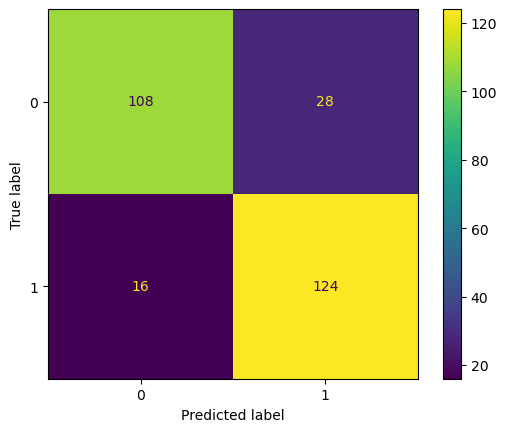

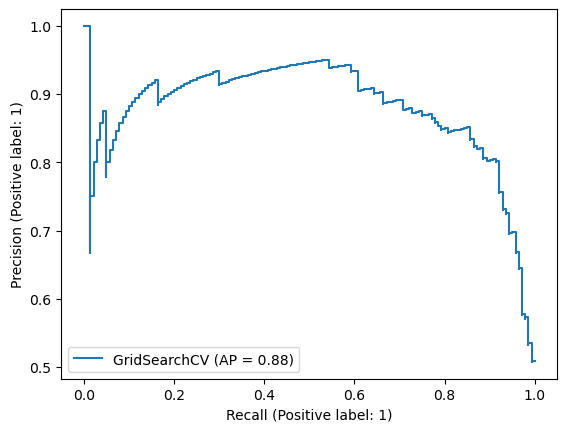

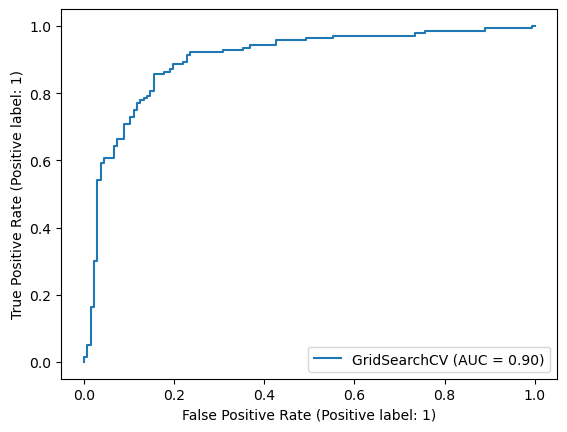

In [ ]:
Eval_Report(svm_grid, ypred_svm_grid)

# 2) Decision Tree

In [ ]:
from sklearn.tree import DecisionTreeClassifier

### Pipeline

In [ ]:
DT_pipe = Pipeline([('scaler', StandardScaler()), ('DT', DecisionTreeClassifier(random_state=101))])

In [ ]:
param_grid= {'DT__max_features': ['auto','sqrt','log2'],
            'DT__criterion': ['gini','entropy']}

DT_grid=GridSearchCV(DT_pipe, param_grid, cv=5)

In [ ]:
DT_grid.fit(X_train,y_train)

In [ ]:
DT_grid.best_params_

### Predict

In [ ]:
ypred_DT_grid = DT_grid.predict(X_test)

### Evaluation

In [ ]:
Eval_Report(DT_grid, ypred_DT_grid)

# 3) Random Forest

In [ ]:
from sklearn.ensemble import RandomForestClassifier

### Pipeline

In [ ]:
RF_pipe = Pipeline([('scaler', StandardScaler()), ('RF', RandomForestClassifier(random_state=101))])

In [ ]:
param_grid= {'RF__n_estimators':[64,70, 78, 88, 95, 100, 120],
            'RF__bootstrap':[True, False],
            'RF__max_features': ['auto','sqrt','log2']}

RF_grid=GridSearchCV(RF_pipe, param_grid, cv=5)

In [ ]:
RF_grid.fit(X_train, y_train)

In [ ]:
RF_grid.best_params_

### Predict

In [ ]:
ypred_RF_grid= RF_grid.predict(X_test)

### Evaluation

In [ ]:
Eval_Report(RF_grid, ypred_RF_grid)

# Conclusion

Our SVM model is the best because with the same accuracy as Random Forest it has more AP and AUC...

Decision Tree is the worst by far :)